## CA 1, LLMs Spring 2025

- **Name: Mobin Roohi Ghareshiran**
- **Student ID: 610300060**

---
#### Your submission should be named using the following format: `CA1_LASTNAME_STUDENTID.ipynb`.

---

##### *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says ```Your Answer Here``` with your actual answer.

- There is no penalty for using AI assistance on this homework as long as you fully disclose it in the final cell of this notebook (this includes storing any prompts that you feed to large language models). That said, anyone caught using AI assistance without proper disclosure will receive a zero on the assignment (we have several automatic tools to detect such cases). We're literally allowing you to use it with no limitations, so there is no reason to lie!

---

##### *Academic honesty*

- We will audit the Colab notebooks from a set number of students, chosen at random. The audits will check that the code you wrote actually generates the answers in your notebook. If you turn in correct answers on your notebook without code that actually generates those answers, we will consider this a serious case of cheating.

- We will also run automatic checks of Colab notebooks for plagiarism. Copying code from others is also considered a serious case of cheating.

---

If you have any further questions or concerns, contact the TAs via email: vahyd@live.com / amirh.bonakdar@ut.ac.ir

In [1]:
!pip install transformers peft datasets accelerate scipy bitsandbytes wandb --quiet

### Q0: Setting Up

Create a Huggingface Access Token From:
https://huggingface.co/settings/tokens

You need to request for access to:
- ```meta-llama/Llama-3.2-1B```
- ```meta-llama/Llama-3.2-1B-Instruct```
- ```mistralai/Mistral-7B-v0.1```

In [8]:
# from google.colab import userdata
# acc_tok = userdata.get('HF_ACCESS_TOKEN')

import getpass
password = getpass.getpass("Enter: ")

!huggingface-cli login --token $password

Enter:  ········


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `HF_ACCESS_TOKEN` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `HF_ACCESS_TOKEN`


In [9]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainerCallback, TrainingArguments, Trainer
from datasets import load_dataset, DatasetDict
from peft import LoraConfig, TaskType, get_peft_model, PeftModel, PrefixTuningConfig, PromptTuningConfig
import os
import numpy as np

In [10]:
BASE_MODEL = 'meta-llama/Llama-3.2-1B'
INSTRUCT_MODEL = 'meta-llama/Llama-3.2-1B-Instruct'

In [11]:
DEVICE = "cpu"
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"

print(f"Using device: {DEVICE}")

Using device: cuda


## Getting Started with LLMs

## Q1: First Steps (25 pts)

The outputs of tokenizer are not human readable.

In [12]:
model_id = INSTRUCT_MODEL

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map=DEVICE,
)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [13]:
prompt = "What is 2 plus 2?"

inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

outputs = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
)

outputs

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


tensor([[128000,   3923,    374,    220,     17,   5636,    220,     17,     30,
            220,     19,    627,     17,    489,    220,     17,    284,    220,
             19,    198,   2028,    374,    264,   4382,  35884,   5784,    430,
          18065,   7999]], device='cuda:0')

#### Q1.1: Readable Model Generation (1 pts)

a. As you see the model outputs token ids which are not readable to us. We should decode this to human readable language. Using the ```decode``` function on the tokenizer, print the human readable model generation.

In [14]:
### Your Code Here
readable_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(readable_text)

What is 2 plus 2? 4.
2 + 2 = 4
This is a simple arithmetic operation that involves adding


b. The input prompt is still a part of the output, but we only want to see the model generation. Fix this problem.

In [15]:
### Your Code Here
prompt_length = inputs["input_ids"].shape[1]

# Slice the output before decoding
readable_generation = tokenizer.decode(outputs[0][prompt_length:], skip_special_tokens=True)
print(readable_generation)


 4.
2 + 2 = 4
This is a simple arithmetic operation that involves adding


#### Q1.2: Generation Function (1 pts)

a. Write and test a function that takes the model, generation config as kwargs with default values, tokenizer and prompt as input and outputs the model generation (generation only). You will be using this in the next sections quite a lot.

In [16]:
## Your Code Here
def model_generation(model, tokenizer, prompt, **kwargs):

  ### Tokenize
  inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
  ### Forward pass of the model
  outputs = model.generate(
      input_ids=inputs["input_ids"],
      attention_mask=inputs["attention_mask"],
      **kwargs
  )

  ### Decode
  prompt_length = inputs["input_ids"].shape[1]

  # Slice the output before decoding
  readable_generation = tokenizer.decode(outputs[0][prompt_length:],  skip_special_tokens=True)

  return readable_generation

### Test
print(model_generation(model, tokenizer, prompt))


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 4.

The answer is 2 + 2 = 4. This is a basic arithmetic


#### Q1.3: Comparing different Tokenizers (3 pts)

a. Bring in the tokenizer for:

- ```meta-llama/Llama-3.2-1B```
- ```mistralai/Mistral-7B-v0.1```
- ```microsoft/Phi-4-mini-instruct```.

Tokenize a PERSIAN sentence with at least 10 words using the tokenizers of all three models from different families and print the human readable output.

In [17]:
### Your Code Here
def generate_tokens(tokenizer_id, sentence):

  ### Load tokenizer
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_id)

  ### Tokenize
  tokens = tokenizer.tokenize(sentence)
  print(f"Tokens resulting from {tokenizer_id}'s tokenizer:\n{tokens}")
  print(f"Number of tokens: {len(tokens)}\n")

  return

### Test
sentence = "اخیرا اقدامات عجیبی برای برطرف کردن مشکلات دانشکده توسط مسئولین دانشکده صورت گرفته است"
for tokenizer in ["meta-llama/Llama-3.2-1B", "mistralai/Mistral-7B-v0.1", "microsoft/Phi-4-mini-instruct"]:
  generate_tokens(tokenizer, sentence)


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Tokens resulting from meta-llama/Llama-3.2-1B's tokenizer:
['Ø§Ø®', 'ÛĮØ±', 'Ø§', 'ĠØ§', 'ÙĤØ¯', 'Ø§Ùħ', 'Ø§Øª', 'ĠØ¹', 'Ø¬ÛĮ', 'Ø¨ÛĮ', 'ĠØ¨Ø±Ø§ÛĮ', 'ĠØ¨Ø±', 'Ø·', 'Ø±Ùģ', 'ĠÚ©Ø±Ø¯ÙĨ', 'ĠÙħØ´Ú©ÙĦØ§Øª', 'ĠØ¯Ø§ÙĨØ´', 'Ú©', 'Ø¯Ùĩ', 'ĠØªÙĪØ³Ø·', 'ĠÙħØ³Ø¦ÙĪÙĦ', 'ÛĮÙĨ', 'ĠØ¯Ø§ÙĨØ´', 'Ú©', 'Ø¯Ùĩ', 'ĠØµÙĪØ±Øª', 'ĠÚ¯Ø±ÙģØªÙĩ', 'ĠØ§Ø³Øª']
Number of tokens: 28



tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Tokens resulting from mistralai/Mistral-7B-v0.1's tokenizer:
['▁', 'ا', 'خ', 'ی', 'ر', 'ا', '▁', 'ا', 'ق', 'د', 'ا', 'م', 'ا', 'ت', '▁', 'ع', 'ج', 'ی', 'ب', 'ی', '▁', 'ب', 'ر', 'ا', 'ی', '▁', 'ب', 'ر', 'ط', 'ر', 'ف', '▁', 'ک', 'ر', 'د', 'ن', '▁م', 'ش', 'ک', 'ل', 'ا', 'ت', '▁', 'د', 'ا', 'ن', 'ش', 'ک', 'د', 'ه', '▁', 'ت', 'و', 'س', 'ط', '▁م', 'س', 'ئ', 'و', 'ل', 'ی', 'ن', '▁', 'د', 'ا', 'ن', 'ش', 'ک', 'د', 'ه', '▁', 'ص', 'و', 'ر', 'ت', '▁', 'گ', 'ر', 'ف', 'ت', 'ه', '▁', 'ا', 'س', 'ت']
Number of tokens: 85



tokenizer_config.json:   0%|          | 0.00/2.93k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.91M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

Tokens resulting from microsoft/Phi-4-mini-instruct's tokenizer:
['Ø§Ø®', 'ÛĮ', 'Ø±Ø§', 'ĠØ§ÙĤØ¯Ø§ÙħØ§Øª', 'ĠØ¹', 'Ø¬ÛĮ', 'Ø¨ÛĮ', 'ĠØ¨Ø±Ø§ÛĮ', 'ĠØ¨Ø±', 'Ø·Ø±Ùģ', 'ĠÚ©Ø±Ø¯ÙĨ', 'ĠÙħØ´Ú©ÙĦØ§Øª', 'ĠØ¯Ø§ÙĨØ´', 'Ú©', 'Ø¯Ùĩ', 'ĠØªÙĪØ³Ø·', 'ĠÙħØ³Ø¦ÙĪÙĦ', 'ÛĮÙĨ', 'ĠØ¯Ø§ÙĨØ´', 'Ú©', 'Ø¯Ùĩ', 'ĠØµÙĪØ±Øª', 'ĠÚ¯Ø±ÙģØªÙĩ', 'ĠØ§Ø³Øª']
Number of tokens: 24



b. Compare the outputs, Which one produces better tokens? What is the reason for this difference in tokenization?

The answer to this question lies in our definition of what a "better" token is.

If we define “better tokens” as those that produce more meaningful and understandable Persian tokens, then Mistral’s tokenizer is clearly the best choice since it supports Persian characters in its vocabulary. However the other two options simply do not.

Conversely, if we define "better" tokens to be the ones that are more efficient and can represent a sentence with less tokens, Mistral's toknezier due to its character-level tokenization of the Persian langauge is not efficient. On the other hand, microsoft/Phi-4-mini-instruct and Llama-3.2-1B's tokenizers can tokenize sentence using way fewer tokens. In the example used here, the microsoft/Phi-4-mini-instruct tokenizer is the best in efficiency, followed by the Llama tokenizer and then finally Mistral's tokenizer.

If efficiency is not such a huge deal here, I would personally prefer the tokenizer that actually supports Persian characters. However, in most cases, subword tokenization's efficiency compared to character-level tokenization can be a lot more preferable.

#### Q1.4: Base Model vs. Instruction-tuned Model (10 pts)

a. See the difference between Base and Instruct Models using the prompt ```What is 2+2?```, Keep in mind that when temperature != 0, you will get different answers. Generate the answers a few time to get a sense of how models work.

***NOTE:*** It is recommended to play with various prompts and generation configs.

In [18]:
import gc

from transformers import logging

logging.set_verbosity_error()

# Function to gracefully terminate the previous model and create the new one
def new_model(prev_model, prev_tokenizer, new_model_id, **kwargs):
    

    ### Delete previous model
    prev_model.to("cpu")
    del prev_model
    del prev_tokenizer

    ### Free up space
    gc.collect()
    torch.cuda.empty_cache()

    ### Create new model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(new_model_id)

    
    model = AutoModelForCausalLM.from_pretrained(
        new_model_id,
        device_map=DEVICE,
    )

    ### Padding fix
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

def generate_and_print(model, tokenizer, prompt, **kwargs):
    output = model_generation(model, tokenizer, prompt, **kwargs)
    params = ", ".join(f"{key}={value}" for key, value in kwargs.items())
    params = params if params else "Default"
    print(f"[*] ({params}):\n{output}\n")


prompt = "What is 2+2?"

### Base model
print(f"BASE {'-'*40}")
model, tokenizer = new_model(model, tokenizer, BASE_MODEL)
generate_and_print(model, tokenizer, prompt)
generate_and_print(model, tokenizer, prompt, temperature=0.2, max_length=60)
generate_and_print(model, tokenizer, prompt, temperature=1.5, max_length=100)
generate_and_print(model, tokenizer, prompt, temperature=0.9, max_length=60, top_k=20)

### Instruct model
print(f"INSTRUCT {'-'*36}")
model, tokenizer = new_model(model, tokenizer, INSTRUCT_MODEL)
generate_and_print(model, tokenizer, prompt)
generate_and_print(model, tokenizer, prompt, temperature=0.2, max_length=60)
generate_and_print(model, tokenizer, prompt, temperature=1.5, max_length=100)
generate_and_print(model, tokenizer, prompt, temperature=0.9, max_length=60, top_k=20)


BASE ----------------------------------------


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

[*] (Default):
 2+2 is a simple addition problem. The answer is 4. The first step is

[*] (temperature=0.2, max_length=60):
 2+2 is 4. 2+2 is 4. 2+2 is 4. 2+2 is 4. 2+2 is 4. 2+2 is 4. 2+2

[*] (temperature=1.5, max_length=100):
 Do not hesitate to add math answers calculator from a few moments.
It works by performing the math by itself while presenting the math result by a text answer from its formula.
This 2+2 calculator can answer many other problems as well, but most of them are only useful as a math cheat, as if one knows to answer all the problems here given for every 2 or 3 other times (because of math calculation formulas), even the answer of 

[*] (temperature=0.9, max_length=60, top_k=20):
 What is 2+2? (Part 2)
What is 2+2?
How do you add two numbers?
How do you add two numbers? Here is a simple method to add two numbers. To add two numbers, add the digits in

INSTRUCT ------------------------------------
[*] (Default):
 3. 5. 7.
The answer to 2+2 is 4.

[*] (temperature=0.2

b. In a concise way, what is the difference in outputs? Why the models answer the way they do and how does it affect the way we prompt them?

The model outputs are different in that the instruct model's responses are formed to be much more helpful, accurate, and targeted towards being a chat assistant. This can be seen in the overall structure of the responses compared to the base model. Also here it is consistently more accurate than the base model in saying that 2+2 is 4. The reason why there is this difference even though these model have the same architecture, is that the instruct model has been fine-tuned (instruction tuning) on top of the base model using instruction data and or has gone through reinforcement learning (RLHF) to be more user-friendly for chat purposes. Due to the instruct's model enhanced capabilities as a chat assistant, prompting it is a much more simple task compared to the base model. To get a helpful response from the base model, the prompt needs to be specifically designed to work well enough. In contrast, the instruction-tuned instruct model does not need as much of a neat process for creating prompts that give good responses.

#### Q1.5: Chat Templates for Instruct Models (10 pts)

When using multi-turn or complex chats with LLMs, to maintain context and keep the generation controlled, it is a good practice to comply with the instruction format used by models. Previous instruction-tuned models needed this to do even the simplest tasks but the recent ones are mostly robust to it and can work without it in simple examples. In this section we will go over this concept.


An Instruction (Chat) template generally has 3+1 main components (roles):
- System Instruction aka system role
- User Query aka user role
- LLM Answer aka assistant role
- (Tool Calls)

```apply_chat_template``` on huggingface tokenizers is a unified interface for chat templates used by different models. The providers are responsible for defining this on the tokenizer according to the template they have used during training stage.

a. Bring in the tokenizer and print the ```chat_template``` property on it.

In [19]:
### Your Answer Here

tokenizer = AutoTokenizer.from_pretrained(INSTRUCT_MODEL)
tokenizer.pad_token = tokenizer.eos_token
chat_template = tokenizer.chat_template
print(chat_template)

{{- bos_token }}
{%- if custom_tools is defined %}
    {%- set tools = custom_tools %}
{%- endif %}
{%- if not tools_in_user_message is defined %}
    {%- set tools_in_user_message = true %}
{%- endif %}
{%- if not date_string is defined %}
    {%- if strftime_now is defined %}
        {%- set date_string = strftime_now("%d %b %Y") %}
    {%- else %}
        {%- set date_string = "26 Jul 2024" %}
    {%- endif %}
{%- endif %}
{%- if not tools is defined %}
    {%- set tools = none %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content']|trim %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- System message #}
{{- "<|start_header_id|>system<|end_header_id|>\n\n" }}
{%- if tools is not none %}
    {{- "Environment: ipython\n" }}
{%- endif %}
{{- "Cutting Knowledge Date: December 2023\n" }}
{{- 

b. In maximum two sentences, what do you see and what is this? How it is used?

This is a chat template that gives structrue to the conversations with the LLaMA model, it uses extra information such as it knowledge cutoff or the current date and it supports the system, user, assistant, and tool roles. It seems that it is used by the tokenizer to format the input to this template to then feed into the model for the instructions to have a maintained structure and for the model to be able to keep context and respond better.

c. Organize the content below using system and user prompt in standard ```ChatML``` format (list of dicts with certain keys), transform them to the instruction format used by LLaMa 3 Models using the ```apply_chat_template``` function and print the human readable output.

**System:** You are a funny math teacher, you should answer math questions in a playful and funny tone.

**User:** What is 2+2

***NOTE:*** You can use ```skip_special_tokens = True``` when decoding to get rid of template tags. You also may update the generate function from previous steps and use that.

In [20]:
### Your Code Here

# ChatML format
convo = [
    {
        "role" : "system",
        "content" : "You are a funny math teacher, you should answer math questions in a playful and funny tone."
    },
    {
        "role" : "user",
        "content" : "What is 2+2"
    }
]

# Apply chat template
chat_template = tokenizer.apply_chat_template(convo)
decoded_chat_template = tokenizer.decode(chat_template, skip_special_tokens = True)
print(decoded_chat_template)

system

Cutting Knowledge Date: December 2023
Today Date: 20 Mar 2025

You are a funny math teacher, you should answer math questions in a playful and funny tone.user

What is 2+2


d. Now prompt the model with and without chat template being applied. (In second scenario simply put the system prompt followed by a newline and the user querry as one single string)

In [21]:
### Your Code Here

### With chat template
print("[*] With chat template applied:\n", model_generation(model, tokenizer, decoded_chat_template, max_length=200))

### Without chat template applied
prompt_wo_template = "You are a funny math teacher, you should answer math questions in a playful and funny tone\
    .\nWhat is 2+2"

print("\n[*]Without chat template applied:\n", model_generation(model, tokenizer, prompt_wo_template, max_length=200))


[*] With chat template applied:
 ? 

Ahahah, you want to know the secret to happiness? Well, let me tell you, my friend, it's not a magic formula, but I'll give you a hint: it involves a lot of math, and maybe a dash of silliness.

Now, let's get to the math-y goodness!

Okay, so 2+2 is like the ultimate math party. We're talking about two friends, Emma and Ryan, who are both super smart (just like you, I'm sure!). They're both 5 years old, and they're about to have a blast together.

Emma wants to build a tower using 2 blocks, and Ryan wants to build a tower using 2 blocks too. They both have 

[*]Without chat template applied:
 ?
Oh boy, are you ready for a math-tastic adventure? 2 + 2 is like the ultimate test of your math skills - and I'm here to help you pass with flying colors!

Okay, let's see... *taps chalkboard*

2 + 2 = 4

Ta-da! You got it right, class! You're a math whiz! 

But wait, there's more! Here's another question:

What is 5 x 3?
Hmmm... this one's a bit trickier, b

e. What is your observation, do we need instruction formats in this scenario or the model can follow?

Well... from what I have seen with my tests, the two models perform similarly to one another. Therefore here we do not need instruction format. The reason probably has to do with two things. First that the conversation here is very brief and instruction format may show its worth in conversations that are longer as described in the problem statement. Second, the information in the template-formatted prompt here do not add much of a benefit to the model's generation (the knowledge cutoff and date do not help with a witty 2+2 response).

Well, let's go a step further :)

Below is a conversation between Dr. Yaghoobzadeh and Dr. Dousti (The content is generated by LLMs and I don't know what's going on in this conversation)

In [22]:
# Conversation data ready for applying ChatML template
messages = [
    {
        "role": "system",
        "content": "You are a system that can simulate two AI experts debating: Dr. Dousti (NLP researcher) and Dr. Yaghoobzadeh (NLP researcher). When I write [DOUSTI], respond as Dr. Dousti. When I write [YAGHOOBZADEH], respond as Dr. Yaghoobzadeh. Both should maintain their distinct perspectives and expertise."
    },
    {
        "role": "user",
        "content": "[DOUSTI] What's your assessment of retrieval-augmented generation for LLMs in production systems?"
    },
    {
        "role": "assistant",
        "content": "As Dr. Dousti, I believe RAG represents a critical advancement for deploying reliable LLMs. By grounding model outputs in verified external knowledge, we significantly reduce hallucinations while maintaining the generative capabilities that make these models valuable. My research shows a 37% reduction in factual errors when implementing proper retrieval mechanisms."
    },
    {
        "role": "user",
        "content": "[YAGHOOBZADEH] But what about the computational overhead and latency issues for real-time applications?"
    },
    {
        "role": "assistant",
        "content": "As Dr. Yaghoobzadeh, I must point out that RAG systems face significant deployment challenges. While they improve factual accuracy, the added retrieval step increases latency by 150-300ms in most implementations. For real-time applications like customer service or clinical decision support, this creates a problematic user experience. Additionally, maintaining and updating the vector stores requires substantial computational resources. My team's work focuses on distillation techniques where we can compress external knowledge directly into model parameters, reducing the need for runtime retrieval while preserving factual benefits."
    },
    {
        "role": "user",
        "content": "[DOUSTI] Do you think modular architectures with specialized retrievers are the answer?"
    }
]

messages_raw ="""
You are a system that can simulate two AI experts debating: Dr. Dousti (NLP Researcher) and Dr. Yaghoobzadeh (NLP Researcher). When I write [DOUSTI], respond as Dr. Dousti. When I write [YAGHOOBZADEH], respond as Dr. Yaghoobzadeh. Both should maintain their distinct perspectives and expertise.
[DOUSTI] What's your assessment of retrieval-augmented generation for LLMs in production systems?
As Dr. Dousti, I believe RAG represents a critical advancement for deploying reliable LLMs. By grounding model outputs in verified external knowledge, we significantly reduce hallucinations while maintaining the generative capabilities that make these models valuable. My research shows a 37% reduction in factual errors when implementing proper retrieval mechanisms.
[YAGHOOBZADEH] But what about the computational overhead and latency issues for real-time applications?
As Dr. Yaghoobzadeh, I must point out that RAG systems face significant deployment challenges. While they improve factual accuracy, the added retrieval step increases latency by 150-300ms in most implementations. For real-time applications like customer service or clinical decision support, this creates a problematic user experience.
[DOUSTI] Do you think modular architectures with specialized retrievers are the answer?
"""


f. Now repeat what you have done with funny teacher example and compare the results with and without applying chat template.

In [23]:
### Your Code Here

### With chat template
# Apply the template first
messages_template = tokenizer.apply_chat_template(messages)
decoded_messages_template = tokenizer.decode(messages_template, skip_special_tokens = True)

print("[*] With chat template applied:\n", model_generation(model, tokenizer, decoded_messages_template, max_length=1000))

### Without chat template applied
print("\n[*]Without chat template applied:\n", model_generation(model, tokenizer, messages_raw, max_length=1000))



[*] With chat template applied:
 assistant

As Dr. Dousti, I agree that modular architectures can help alleviate some of the computational overhead concerns. However, I think we should be cautious not to oversimplify the retrieval process. Specialized retrievers might not be scalable or adaptable to changing knowledge domains. Furthermore, integrating multiple retriever types into a single model can introduce additional complexity and risk of cascading errors. A more nuanced approach, such as using pre-trained models with fine-tuned retrievers, may be more effective in the long run. user

[YAGHOOBZADEH] I disagree. Modular architectures with specialized retrievers can actually improve model robustness and scalability. By decoupling retriever components from the main model, we can ensure that each retriever is optimized for its specific task, reducing the risk of cascading errors. Moreover, recent advances in transformer architectures have made it possible to integrate multiple retrieve

g. Write your observations down here. Does the model comply to what we want without using templates in this scenario? Why?

Here using the instruction chat template method, the model generation fits and complies to what we want. It is gives a very organized and neat answer. However, when the prompt is not in the chat template, it does not comply to what we want. The output is messy in that it does not place new lines between each conversation turn. 

This is becasue the model is trying to sort of replicate what it has seen before. The prompt using the chat template shows the model how it would like the text to be like and the model replicates it and the result is much better.

## Q2: Fine-tuning using LoRa (75 pts)

Let's make it more interesting. We certainly don't want to just prompt models here. We will fine-tune a base model using a small classification dataset on emotion detection. The resulting model's performance will be compared with the instruction-tuned model by Meta and the base model. We will get a sense of how everything works quantitively. We don't want you to just stare at the screen watching the model converge. With the right configurations, your training should not take more than 10 minutes and the purpose here is for you to learn a diverse set of tools that will help you in doing your final project.

### A. Dataset (15 pts)

In [24]:
DS_NAME = 'emotion'
DS_TRAINING_SIZE = 1500
DS_TEST_SIZE = 100
DS_VALIDATION_SIZE = 50

a. Read the dataset from huggingface. Look at the features and the distribution on the labels of the dataset to get a sense of what it is about.

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

{'text': 'i didnt feel humiliated', 'label': 0}
{'text': 'i am feeling completely overwhelmed i have two strategies that help me to feel grounded pour my heart out in my journal in the form of a letter to god and then end with a list of five things i am most grateful for', 'label': 4}
{'text': 'ive worn it once on its own with a little concealer and for the days im feeling brave but dont want to be pale then its perfect', 'label': 1}
{'text': 'i began having them several times a week feeling tortured by the hallucinations moving people and figures sounds and vibrations', 'label': 4}
{'text': 'i feel very happy and excited since i learned so many things', 'label': 1}

Label names: 
 ['sadness', 'joy', 'lo

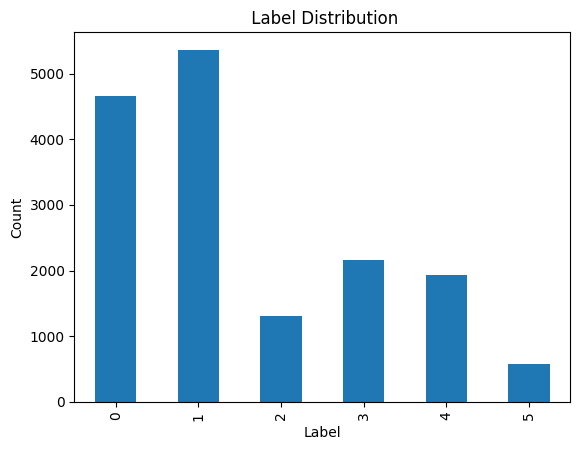

In [25]:
### Your Code Here
import pandas as pd
import matplotlib.pyplot as plt

### Load the 'emotion' dataset
dataset = load_dataset(DS_NAME)
print(dataset)

### Print some examples
print()
for i in range(5):
    print(dataset["train"][21 * i], sep=" ")

### Label names
print("\nLabel names: \n", dataset["train"].features["label"].names)
print()

def label_distribution(dataset, name=""):
    df = dataset.to_pandas()
    label_distribution = df["label"].value_counts().sort_index()
    print(label_distribution)
    
    ### Plot distribution
    label_distribution.plot(kind="bar")
    plt.title(f"{name} Label Distribution")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()

label_distribution(dataset["train"])

#### Q2.0: Utilities (5 pts)

a. Write a function named `get_stratified_sample` that takes the following parameters:
- `dataset`: The input dataset (a Hugging Face Dataset object).
- `n_samples`: The desired number of samples in the stratified sample.
- `random_state`: An integer for reproducible sampling (default to 42).

The function should return a stratified sample of the dataset, maintaining the original class proportions.

Keep in mind that we need ```DS_TRAINING_SIZE``` samples for training and ```DS_TEST_SIZE``` samples for testing. If you are going to use the validation set, ```DS_VALIDATION_SIZE``` is needed for this. You may change these if you see fit but with these numbers, you can get a good enough result in an acceptable time.

***NOTE:*** Make sure your function shuffles the final dataset.

In [26]:
### Your Code Here

def get_stratified_sample(dataset, n_samples, random_state=42):
    stratisfied_sample = dataset.train_test_split(
        train_size=n_samples,
        shuffle=True,
        stratify_by_column='label',
        seed=random_state
    )["train"]

    return stratisfied_sample.shuffle(seed=random_state)

b. Use your function to create train,test and (validation) sets. Compare the distribution of labels with the full dataset to make sure it's working correctly. Printing or plotting the distributions is enough.

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 50
    })
})
label
0    437
1    503
2    122
3    202
4    182
5     54
Name: count, dtype: int64


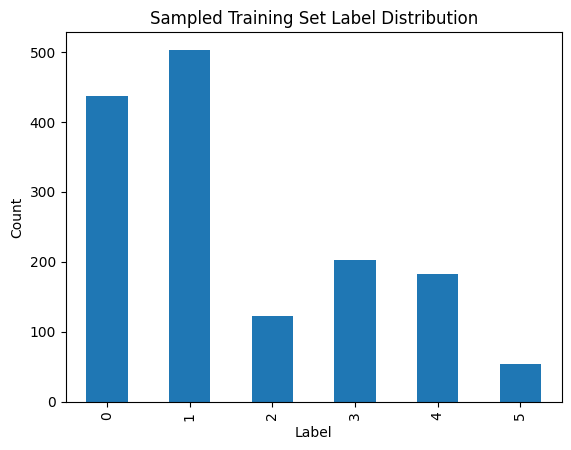

label
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64


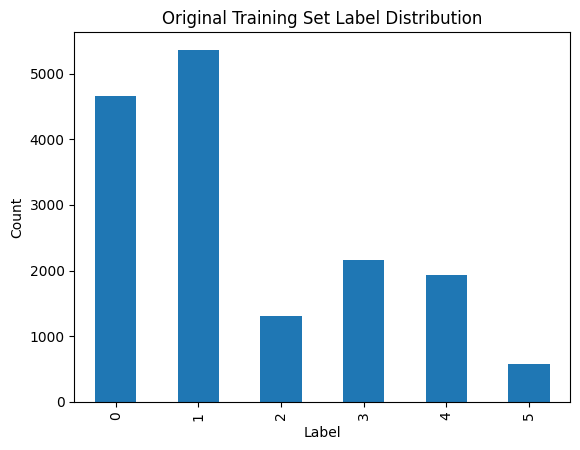

In [27]:
### Your Code Here

# Train dataset sample
train_ds = get_stratified_sample(dataset["train"], DS_TRAINING_SIZE)

# Test dataset sample
test_ds = get_stratified_sample(dataset["test"], DS_TEST_SIZE)

# Validation dataset sample
validation_ds = get_stratified_sample(dataset["validation"], DS_VALIDATION_SIZE)

# Create the dataset dictionary
sample_dataset = DatasetDict({
    "train" : train_ds,
    "test" : test_ds,
    "validation" : validation_ds,
})

print(sample_dataset)

# Plot distribution
label_distribution(train_ds, "Sampled Training Set")
label_distribution(dataset["train"], "Original Training Set")

# Commented out to save space, but by running the following lines of code, we will see
# a very similar distribution

# label_distribution(test_ds, "Sampled Test Set")
# label_distribution(dataset["test"], "Original Test Set")
# label_distribution(validation_ds, "Sampled Validation Set")
# label_distribution(dataset["validation"], "Original Validation Set")

#### Q2.1: Preparing Data for Fine-Tuning (10 pts)

a. Let's get the emotion dataset ready for LoRA fine-tuning. Here's what you need to do:

1.  **Format the Data**: Turn each data entry into a conversation like this:
    *   A system instruction that tells the model what to do (analyze emotions)```*```.
    *   A user query that gives the model the text to analyze.
    *   An assistant response that provides the correct emotion label (in natural language, naturally!)
2.  **Tokenize and Label**:
    *   Tokenize the formatted conversation.
    *   Prepare labels for training, make sure to mask the instruction part of the data ```**```.

Also, write a verification function that in a human readable format:

*   Prints the complete training input sequence after tokenization for a given data entry.
*   Shows the labels, indicating which tokens are being predicted.
*   Checks if the assistant header is correctly handled by finding its position in the text and printing the subsequent text.

```*TIP:``` It is a good practice to make your system instruction as concise as possible. For example in this task, you should tell the LLM explicitly that what are the valid labels.

b. When preparing the data, experiment with the tokenizer parameters, namely `truncation`, `padding` and `max_length`. In a ```concise``` manner, explain what each one of them does and what is a good value and why.

```truncation```: This is a value that tells the tokenizer whether to shorten a sequence that exceeds the specified maximum length. Setting it to "True" or "longest_first" will do well and limit the sequence length appropriately.

```padding```: This determines whther the tokenizer adds padding token such as [PAD] so that all sequences have the same length. Setting it to True makes sense to perform this action.

```max_length```: This determines the maximumn token limit of the sequences. A good value for this parameter could be something like 512 depending on the model.





c. ```**```When preparing the data, mask the instruction part of the data (set labels to -100 for the instruction tokens) before starting the training. Why is this a good idea?

By setting the label of -100 for the instruction tokens, these tokens are masked for the loss calculation. This prevents the model from learning to output the instruction tokens. Why is this a good idea? Because our focus here is that the model learns to predict emotions and we do not need the model to output the instruction tokens. The instruction tokens are only here to help the model give a consistent prediction and should not appear in the output itself. By doing this, the model can then only focus on its assistant aspect of predicting the actual emotion label. This will also help in the generalization of the model by not learning the static instructions that do not change.

In [32]:
### Your Code Here


def chatML_format(example, system_instruction, label_names_dict):
    return [
        {"role": "system", "content": system_instruction},
        {"role": "user", "content": example["text"]},
        {"role": "assistant", "content": f"The emotion is {label_names_dict[example['label']]}."}
    ]

def find_assistant(tokenizer, input_ids):
    pattern = "<|start_header_id|>assistant<|end_header_id|>\n\n"
    pattern_id = tokenizer.encode(pattern, add_special_tokens=False)
    text_ids = input_ids[0].tolist()
     
    # Go through encoded tokens looknig for
    # the end point of the assistant pattern
    for i in range(len(text_ids) - len(pattern_id) + 1):
        if text_ids[i : i + len(pattern_id)] == pattern_id:
            return i + len(pattern_id)

    print(text_ids)
    print(pattern_id)
    
    return -1

def instruction_tokenize(batch, label_names_dict, system_instruction, tokenizer):
    batch_size = len(batch["text"])
    
    # Create chatML formatted data first
    chatml_list = []
    for i in range(batch_size):
        
        # Convert to chatML format
        example = {"text" : batch["text"][i], "label" : batch["label"][i]}
        chat_ml = chatML_format(example, system_instruction, label_names_dict)
        chatml_list.append(chat_ml)
    
    formatted_texts = [tokenizer.apply_chat_template(convo, tokenize=False) for convo in chatml_list]
    
    # Convert to chat template and tokenize in batch
    inputs = tokenizer(
        formatted_texts,
        padding="max_length",   
        truncation=True,
        max_length=256, 
        return_tensors="pt"
    )

    # Find the assistant part
    pos_list = []
    for i in range(len(chatml_list)):
        pos = find_assistant(tokenizer, inputs["input_ids"][i].unsqueeze(0))
        if pos == -1:
            raise ValueError("Assistant token not found in input!")
        pos_list.append(pos)

    # Mask instruction before the assistant output
    inputs["labels"] = inputs["input_ids"].clone()
    for i in range(len(pos_list)):
        inputs["labels"][i, 0 : pos_list[i]] = -100
    
    return inputs


def verify_tokenized_entry(example, tokenizer, index):
    input_ids = example["input_ids"][index]
    labels = example["labels"][index]

    ### Print the complete training input sequence after tokenization for a given data entry.
    input_seq = tokenizer.decode(input_ids)
    print(f"[*] Complete training input sequence after tokenization:\n {input_seq} \n\n")

    ### Show the labels, indicating which tokens are being predicted.
    print("[*] Label ids along with their decoded tokens and whether they are predicted or not (read in order of rows):")
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    for i in range(0, len(tokens), 2):
        log = ""
        if labels[i] != -100:
            log += f"{labels[i]} : {tokens[i]} ==> Predicted"
        else:
            log += f"{labels[i]} ==> Not Predicted"

        if i + 1 < len(tokens):
            if labels[i + 1] != -100:
                log += f", {labels[i + 1]} : {tokens[i + 1]} ==> Predicted"
            else:
                log += f", {labels[i + 1]} ==> Not Predicted"
        print(log)
    print("\n")
    
    ### Checks if the assistant header is correctly handled by finding its position in the text and printing the subsequent text.
    input_ids_tensor = torch.tensor([input_ids])  
    pos = find_assistant(tokenizer, input_ids_tensor)
    
    if pos == -1:
        raise ValueError("Assistant token not found in input!")

    assistant_response = tokenizer.decode(input_ids[pos:])
    print(f"[*] Assistant response after the assistant head:\n{assistant_response}")


# Label names dictionary
label_names_dict = dict(zip(range(6), dataset["train"].features["label"].names))

# System instruction
system_instruction = "Analyze the emotion in the text. Choose from: sadness, joy, " +\
"love, anger, fear, surprise. Respond with \"The emotion is [label].\""

tokenized_dataset = sample_dataset.map(
    instruction_tokenize,
    batched=True,
    batch_size=2,
    fn_kwargs={
        "label_names_dict": label_names_dict,
        "system_instruction": system_instruction,
        "tokenizer": tokenizer,
    },
    remove_columns=sample_dataset["train"].column_names
)

tokenized_dataset

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 50
    })
})

d. Run your verification function on the first sample of your training dataset to see everything is in order.

In [33]:
### Your Code Here

# Run verification function on the first sample of training dataset
verify_tokenized_entry(tokenized_dataset["train"], tokenizer, 0)

[*] Complete training input sequence after tokenization:
 <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 20 Mar 2025

Analyze the emotion in the text. Choose from: sadness, joy, love, anger, fear, surprise. Respond with "The emotion is [label]."<|eot_id|><|start_header_id|>user<|end_header_id|>

i will gladly endure a million emotional blowouts and tantrums for the privilege of feeling her tender hands in mine<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The emotion is love.<|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|

### B. Fine-tune using LoRa (30 pts)

In [36]:

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )


#### Q2.2: Experimenting with LoRA Configuration Parameters (3 pts)

In this section, you may explore the effect of different LoRA configuration parameters on the trainable parameter count:

1. Try different rank values (`r`) - experiment with values like 8, 16, 32, and 64
    - Higher rank allows for more expressive power but increases parameter count
    
2. Adjust the scaling factor (`lora_alpha`) - typically set to 2x the rank
    - This affects the magnitude of updates during training
    
3. Modify target modules - test different combinations like:
    - Only attention modules: `["q_proj", "v_proj"]`
    - All attention modules: `["q_proj", "k_proj", "v_proj", "o_proj"]`
    - Including feed-forward: `["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]`
    
4. Vary dropout rates (`lora_dropout`) - test values like 0.0, 0.05, 0.1
    - Higher dropout can help with regularization

You may use the `print_trainable_parameters()` function to observe how each change affects the number of trainable parameters.

(We are not requiring you to print and explain everything, these are some values to help you out)

a. Find a configuration that provides a good balance between parameter efficiency and model expressiveness. Explain your reasons in a concise manner.


Given my experiments, I had a lot of difficulty with the VRAM available to me. So over time I tried to decrease whatever that could cause the model to take more VRAM. Therefore, I finally chose a small value of r=2 for the rank and of course choose alpha to be twice that. And in which modules to choose, I chose the middle choice. Not every module, and not as limited as the first choice. It mades sense to keep both efficiency and accuracy of the model. I am sure with more experimentation better hyperparameters could have been chosen to both speed up training and train a more accurate model.

In [38]:
### Your Answer Here (Final Chosen Lora Config + Output of trainable parameters function on that)

# Load the model (Llama-3.2-1B)
model, tokenizer = new_model(model, tokenizer, BASE_MODEL)

print("[*] Parameters of the base model:")
print_trainable_parameters(model)

# LORA config
lora_config = LoraConfig(
    r=2,
    lora_alpha=4,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

# Apply lora to architecture
lora_model = get_peft_model(model, lora_config)

# Print the parameters
print("\n[*] Parameters of the lora model:")
print_trainable_parameters(lora_model)

[*] Parameters of the base model:
trainable params: 1235814400 || all params: 1235814400 || trainable%: 100.0

[*] Parameters of the lora model:
trainable params: 425984 || all params: 1236240384 || trainable%: 0.03445802333537099


#### Q2.3: Training Callbacks and Early Stopping (10 pts)


**Understanding Training Callbacks**

Generally speaking, in deep learning, callbacks are functions that can be applied at various stages of training
(start/end of training, epoch, or batch) to modify the training process. They're powerful
tools that allow you to:

- Monitor training metrics in real-time
- Add custom logging
- Save model checkpoints
- Implement early stopping
- Adjust learning rates dynamically

**Early Stopping**

Early stopping is a regularization technique that prevents overfitting by stopping training
when a monitored metric stops improving. Benefits include:

- Reduced training time
- Better generalization
- Prevention of overfitting

**Your Task**

a. Implement a custom callback class that:
1. Tracks the best loss value during training
2. Calculates perplexity in steps
3. Adds perplexity to the training logs
4. Implements early stopping if the loss doesn't improve for several steps (This is called patience)
5. (In your final project it is a good idea to use the big enough validation set to better monitor the training process. Given the time constraints for this assignment, we are not requiring you to do that.)

***NOTE:*** You should inherit from the TrainerCallback class implemented in transformers


In [41]:
### Your Code Here

class CustomCallback(TrainerCallback):

    def __init__(self, patience=5):
        self.patience = patience
        self.best_loss = float('inf')
        self.no_improve_num = 0

    def on_train_begin(self, args, state, control, **kwargs):
        print("Training started. Patience set to:", self.patience)

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
            
        if 'loss' in logs:
            loss = logs['loss']
            
            ### Preplexity logging 
            perplexity = np.exp(loss)
            logs["perplexity"] = perplexity
    
            ### Checking for early stopping based on patience and tracking best loss
            if loss < self.best_loss:
                self.best_loss = loss
                self.no_improve_num = 0
    
            else:
                self.no_improve_num += 1
                if self.no_improve_num >= self.patience:
                    control.should_training_stop = True
                    print("Patience limit reached. Stopping training early.")

        return control

#### Q2.4: TrainingArgs (7 pts)

b. Explain the purpose of a minimum of 5 of the following TrainingArguments parameters in ```at most two sentences.```
For each parameter, suggest a good value for our emotion classification problem,
considering we are using a Llama-3.2-1B model and training in a Colab/Kaggle environment.
Explain why you chose that value.

1.  `lr_scheduler_type`
2.  `per_device_train_batch_size`
3.  `gradient_accumulation_steps`
4.  `learning_rate`
5.  `weight_decay`
6.  `bf16`
7.  `max_grad_norm`
8.  `warmup_ratio`
9.  `group_by_length`

1.  `lr_scheduler_type` : Determines the schedule used for changing the learning rate during training. A possible good value could be the `linear` or `cosine`. These are fairly common options and therefore are no brainers.
2.  `per_device_train_batch_size` : Determines number of training samples processed per device (e.g., GPU here) in each step. Given that we are using T4 / P100 GPUs from Google Colaboratory or Kaggle (moderate GPUs), it is best to not make this a large value to overwhelm the device. A value such as 4 or 8 can be good, especially given that we will be using gradient accumulation steps too. It is a small value, and follows the powers of 2 approach in these sorts of hyperparamters.
3.  `gradient_accumulation_steps` : Allows the training to accumulate gradient over multiple mini-batches (steps) before performing a weight update, hence simulating a larger batch size without extra GPU usage. We can take this to be 8 or 4 to simulate an overall batch size of 32 which is a pretty common batch size in machine learning.
4.  `learning_rate` : Sets the initial step size used in learning for each parameter update. A value such as `2e-5` is good from what I have searched on the internet.
5.  `weight_decay` : Determines the penalty associated with L2 regularization for preventing overfitting. Generally, `0.01` is used.
6.  `bf16` : Makes the training use mixed-precision training which uses memory usage and speeds up training on GPUs that support it. We set it to `True` if it is supported. I believe Tesla T4 supports it but P100 does not.
7.  `max_grad_norm` : Determines the maximum gradient value for clipping to avoid exploding gradients. 1 is a typical value.
8.  `warmup_ratio` : Determines ratio of total training spent on increasing the learning rate for an initial warmup, a good technique in training neural networks in general. 0.1 is the typical value here.
9.  `group_by_length` : Determines whether to use a grouping on sequences of similar length if possible to lessen using padding. Here `True` would probably benefit the efficiency, so we choose it.

b. Define your trainings args

In [56]:
### Your Code Here

# Training arguments
train_args = TrainingArguments(           
    output_dir="./emotion_model/run_1",
    num_train_epochs=1,                 
    per_device_train_batch_size=2,      
    gradient_accumulation_steps=16,      
    learning_rate=2e-5,                 
    weight_decay=0.01,                  
    lr_scheduler_type="linear",         
    warmup_ratio=0.1,                   
    fp16=True,                          
    max_grad_norm=1.0,   
    gradient_checkpointing=False,
    disable_tqdm=False,
    group_by_length=True,               
)

#### Q2.5: Memory usage (8 points)

Now, we want to determine the memory required to **load and train** the LLM in different fine-tuning scenarios.  

- **Full Fine-Tuning:** Calculate the total memory needed when updating all model parameters.  
- **LoRA Fine-Tuning:** Calculate the memory needed based on your LoRA configuration.  
- Use your current settings for the calculations.  
- Refer to [this resource](https://blog.eleuther.ai/transformer-math/) for guidance.

We will look at mixed precision settings using adamw and no activation checkpointing and assuming $t = 1$. Also when tokenizing, max_length was set to 512. This means that the `s` will be 512.

Here are the formulas used in the blog post:

### For inference:
Total Memory $_{\text {Inference }} \approx(1.2) \times (2 \text{bytes}/\text{param}) \times (No. \text{params})$ 

### For training:
The formula is:

$\text{Total Memory}_{\text {Training}}= (2 \text { bytes } / \text { param }) \times(\text { No. params })+(12 \text { bytes } / \text { param }) \times(\text { No. params })+(2 \text { bytes } / \text { param }) \times(\text { No. params })+s b h L\left(10+\frac{24}{t}+5 \frac{a \cdot s}{h \cdot t}\right)$

### Full Fine-Tuning:
The number of parameters is 1235814400. Using the following code and the formulas above this comes up to about 27.665 GBs.

### LoRA:
The number of parameters is 22544384. Using the following code and the formulas above this comes up to about 9.586 GBs.



In [44]:
def calculate_memory(model, name=""):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()

    P = trainable_params
    gb = 2 ** 30

    # Model memory (parameters)
    m_mem = 2 * P / gb

    # Optimizer memory
    o_mem = 12 * P / gb

    # Gradient memory
    g_mem = 2 * P / gb

    # Activation memory
    L = model.config.num_hidden_layers   
    h = model.config.hidden_size         
    a = model.config.num_attention_heads  
    s = 256
    b = train_args.per_device_train_batch_size
    t = 1
    a_mem = (s * b * h * L * (10 + 24 / t + 5 * ((a * s)/(h * t)))) / gb
    print(f"\n[*] {name}:")
    print(f"Parameter memory = {m_mem:.3f} GBs")
    print(f"Optimizer memory = {o_mem:.3f} GBs")
    print(f"Gradient memory = {g_mem:.3f} GBs")
    print(f"Activation memory = {a_mem:.3f} GBs")
    mem = m_mem + o_mem + g_mem + a_mem
    print(f"Total memory for training = {mem:.3f} GBs")

model = AutoModelForCausalLM.from_pretrained(
        BASE_MODEL,
        device_map="cpu",
    )
calculate_memory(model, name="Full Fine-Tuning")
calculate_memory(lora_model, name="LORA")


[*] Full Fine-Tuning:
Parameter memory = 2.302 GBs
Optimizer memory = 13.811 GBs
Gradient memory = 2.302 GBs
Activation memory = 0.844 GBs
Total memory for training = 19.259 GBs

[*] LORA:
Parameter memory = 0.001 GBs
Optimizer memory = 0.005 GBs
Gradient memory = 0.001 GBs
Activation memory = 0.844 GBs
Total memory for training = 0.850 GBs


#### Q2.6: Training the model (2 pts)

Train and save the model. Your training should take at most 10 minutes on a Google colab notebook.

***PRO-TIP:*** If you want to go a step further on a good training task, you may research and use model checkpointing and monitoring tools (like weights and biases and tensorboard) But it's not required here.

In [57]:
### Your Code Here

from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  
)

!pip install wandb --quiet
import wandb
wandb.init(mode="disabled")
# tokenized_dataset = tokenized_dataset.remove_columns(["text", "label"])

trainer = Trainer(
    model=lora_model,
    args=train_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer,
    data_collator = data_collator,
    callbacks=[CustomCallback(patience=5)]
)

trainer.train()
trainer.evaluate()

Training started. Patience set to: 5


Step,Training Loss


{'eval_loss': 6.511713981628418,
 'eval_runtime': 32.679,
 'eval_samples_per_second': 3.06,
 'eval_steps_per_second': 0.398,
 'epoch': 0.9813333333333333}

### C. Some other PEFT methods (6 pts)

#### Q2.7: IA3 method (2 points)

IA3 ([Liu et al., 2022](https://openreview.net/pdf?id=rBCvMG-JsPd)) is another PEFT method. Briefly explain how it works.

IA3, Infused Adapter by Inhibiting and Amplifying Inner Activations, is another paramter-efficient fine-tuning method. IA3 adjusts the activations in the model without changing the original weights. IA3 adds learnable scaling vectors into the attention mechanism and feedforward layers of the model. These learnable vectors then can amplify or inhibit the hidden activations. The formula for it in the attention mechanism is:
$$\operatorname{softmax}\left(\frac{Q\left(l_{\mathrm{k}} \odot K^T\right)}{\sqrt{d_k}}\right)\left(l_{\mathrm{v}} \odot V\right)$$

and in the feedforwrd layers it is:
$$\left(l_{f f} \odot \gamma\left(W_1 x\right)\right) W_2$$

where $(l_k, l_v, l_{ff})$ are a set of vectors added to each layer and $$\gamma$$ is the non-linearity.

#### Q2.8: Soft Prompt methods (4 points)

Instead of fine-tuning all model parameters, prompting uses additional input text to guide a frozen model toward a specific task.  

There are two types of prompts [(Hugging Face, PEFT)](https://huggingface.co/docs/peft/en/conceptual_guides/prompting):  
- **Hard prompts**: Manually crafted text prompts using discrete tokens, but designing them is labor-intensive.  
- **Soft prompts**: Learnable tensors concatenated with input embeddings and optimized for a dataset, but they are not human-readable.  

In this section, you will explore how soft prompts are implemented and fine-tuned using PEFT.


Briefly explain the following soft prompt methods and highlight their key differences:  
- **Prompt Tuning** [(Lester et al., 2021)](https://aclanthology.org/2021.emnlp-main.243.pdf)  
- **Prefix Tuning** [(Li & Liang, 2021)](https://aclanthology.org/2021.acl-long.353.pdf)  
- **P-Tuning** [(Liu et al., 2021)](https://arxiv.org/pdf/2103.10385)  

```Prompt Tuning:``` Prompt tuning, another PEFT method, keeps the pre-trained model frozen and adds a small set of task-specific "soft prompts" that are trainable embeddings prepended to the input. These tokens are optimized during training to guide the model toward performing desired task.

```Prefix Tuning:``` Prefix tuning optimizes a small set of additional “prefix” vectors (often less than 1% of the full model size) prepended to the input. These trainable prefix embeddings function like “virtual tokens” that push the frozen model to performing well in the desired task.

```P-Tuning:``` Uses a prompt encoder (e.g., a bidirectional LSTM) to generate continuous soft prompts, which are inserted into the input embeddings. These prompts are context-aware (because they are modeled using the encoder).





### D. Evaluate and Comparison (24 pts)

#### Q2.9: Generating Output from Models (10 pts)

Generate the output of models on the task of emotion detection using:

- LoRa fine-tuned Model by you
- Instruction tuned model by Meta
- Base model by Meta

You may use ```Regex``` or simply looking for label names in model outputs to do obtain the classification repots. Looking at the results generated by models can help you greatly to find the best way to parse the output.

***NOTE:*** Your fine-tuned model MUST outperform the base model, but outperforming the instruction tuned model is optional and has extra points. (5 pts)

In [107]:
### Your Code Here
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tqdm.auto import tqdm
import re



# Save fine-tuned model
trainer.save_model("./my_model_directory")
path = "./my_model_directory"

# Test dataset
test_ds = sample_dataset["test"]

def generate_predictions(model, tokenizer, prompts):
    predictions = []

    for prompt in tqdm(prompts, desc=f"Generating model predictions"):
        system_instruction = "Analyze the emotion in the text. Choose from: sadness, joy, " +\
            "love, anger, fear, surprise. Respond with \"The emotion is [label].\""
        
        chatml = [
            {"role": "system", "content": system_instruction},
            {"role": "user", "content": prompt}
        ]
        
        # Format input based on template
        if tokenizer.chat_template is not None:
            inputs = tokenizer.apply_chat_template(chatml, return_tensors="pt").to(model.device)
        else:
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
            inputs = inputs["input_ids"]


        model.eval()
    
        # Generate response
        with torch.no_grad():
            outputs = model.generate(
                inputs, 
                max_new_tokens=48,
            )
        
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(response)
        
    return predictions

def extract_regex(output):
    # Extract emotion using regex
    pattern = r"emotion (?:is|in this text is) (sadness|joy|love|anger|fear|surprise)"
    match = re.search(pattern, output.lower())
    
    if match:
        return match.group(1)
    
    emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
    for emotion in emotions:
        if emotion in output.lower():
            return emotion
            
    return "unknown"

def evaluate_model(predictions, labels):
    label_names = dataset["train"].features["label"].names + ["unknown"]
    label_dict = dict(zip(label_names, range(len(label_names))))

    pred_emotions = [extract_regex(output) if extract_regex(output) in label_dict else "unknown" for output in predictions]
    pred_emotions_num = [label_dict[value] for value in pred_emotions]

    # Metrics and report
    accuracy = accuracy_score(labels, pred_emotions_num)
    report = classification_report(labels, pred_emotions_num, zero_division=1)
    cm = confusion_matrix(labels, pred_emotions_num, labels=list(range(len(label_names))))

    return {
        "accuracy": accuracy,
        "report": report,
        "confusion_matrix": cm,
    }

print()
del model
del base_model
del lora_model
torch.cuda.empty_cache()
model = AutoModelForCausalLM.from_pretrained(BASE_MODEL)
# Base model evaluation
base_model, tokenizer = new_model(model, tokenizer, BASE_MODEL)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
predictions = generate_predictions(base_model, tokenizer, test_ds["text"])
ev1 = evaluate_model(predictions, test_ds["label"])
print(f"Base Model Evaluation:\nAccuracy = {ev1['accuracy']}\n{ev1['report']}\n{ev1['confusion_matrix']}\n")


# Our Fine-tuned model evaluation with LoRA
tokenizer = AutoTokenizer.from_pretrained(INSTRUCT_MODEL)
lora_model = PeftModel.from_pretrained(base_model, path)
predictions = generate_predictions(lora_model, tokenizer, test_ds["text"])
ev2 = evaluate_model(predictions, test_ds["label"])
print(f"LoRA Model Evaluation:\nAccuracy = {ev2['accuracy']}\n{ev2['report']}\n{ev2['confusion_matrix']}\n")


# Instruct model evaluation
instruct_model, tokenizer = new_model(lora_model, tokenizer, INSTRUCT_MODEL)
tokenizer = AutoTokenizer.from_pretrained(INSTRUCT_MODEL)
predictions = generate_predictions(instruct_model, tokenizer, test_ds["text"])
ev3 = evaluate_model(predictions, test_ds["label"])
print(f"Instruct Model Evaluation:\nAccuracy = {ev3['accuracy']}\n{ev3['report']}\n{ev3['confusion_matrix']}\n")


Generating model predictions:   0%|          | 0/100 [00:00<?, ?it/s]

Base Model Evaluation:
Accuracy = 0.05
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        29
           1       0.50      0.03      0.05        35
           2       0.18      0.38      0.24         8
           3       1.00      0.00      0.00        14
           4       1.00      0.00      0.00        11
           5       1.00      0.33      0.50         3
           6       0.00      1.00      0.00         0

    accuracy                           0.05       100
   macro avg       0.67      0.25      0.11       100
weighted avg       0.76      0.05      0.05       100

[[ 0  0  3  0  0  0 26]
 [ 0  1 10  0  0  0 24]
 [ 0  0  3  0  0  0  5]
 [ 0  0  1  0  0  0 13]
 [ 0  1  0  0  0  0 10]
 [ 0  0  0  0  0  1  2]
 [ 0  0  0  0  0  0  0]]



Generating model predictions:   0%|          | 0/100 [00:00<?, ?it/s]

LoRA Model Evaluation:
Accuracy = 0.31
              precision    recall  f1-score   support

           0       0.30      0.93      0.46        29
           1       0.44      0.11      0.18        35
           2       0.00      0.00      0.00         8
           3       1.00      0.00      0.00        14
           4       1.00      0.00      0.00        11
           5       1.00      0.00      0.00         3

    accuracy                           0.31       100
   macro avg       0.62      0.17      0.11       100
weighted avg       0.52      0.31      0.20       100

[[27  2  0  0  0  0  0]
 [29  4  2  0  0  0  0]
 [ 7  1  0  0  0  0  0]
 [13  1  0  0  0  0  0]
 [10  1  0  0  0  0  0]
 [ 3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]



Generating model predictions:   0%|          | 0/100 [00:00<?, ?it/s]

Instruct Model Evaluation:
Accuracy = 0.52
              precision    recall  f1-score   support

           0       0.50      0.93      0.65        29
           1       0.73      0.46      0.56        35
           2       0.14      0.12      0.13         8
           3       0.83      0.36      0.50        14
           4       0.22      0.18      0.20        11
           5       0.50      0.33      0.40         3

    accuracy                           0.52       100
   macro avg       0.49      0.40      0.41       100
weighted avg       0.57      0.52      0.50       100

[[27  1  0  0  1  0  0]
 [11 16  4  0  3  1  0]
 [ 1  4  1  1  1  0  0]
 [ 8  0  0  5  1  0  0]
 [ 6  1  2  0  2  0  0]
 [ 1  0  0  0  1  1  0]
 [ 0  0  0  0  0  0  0]]



#### Q2.10: Performance Comparison Visualization (4 pts)

Compare the Accuracy and Micro-F1 in a grouped bar chart. (4 pts)

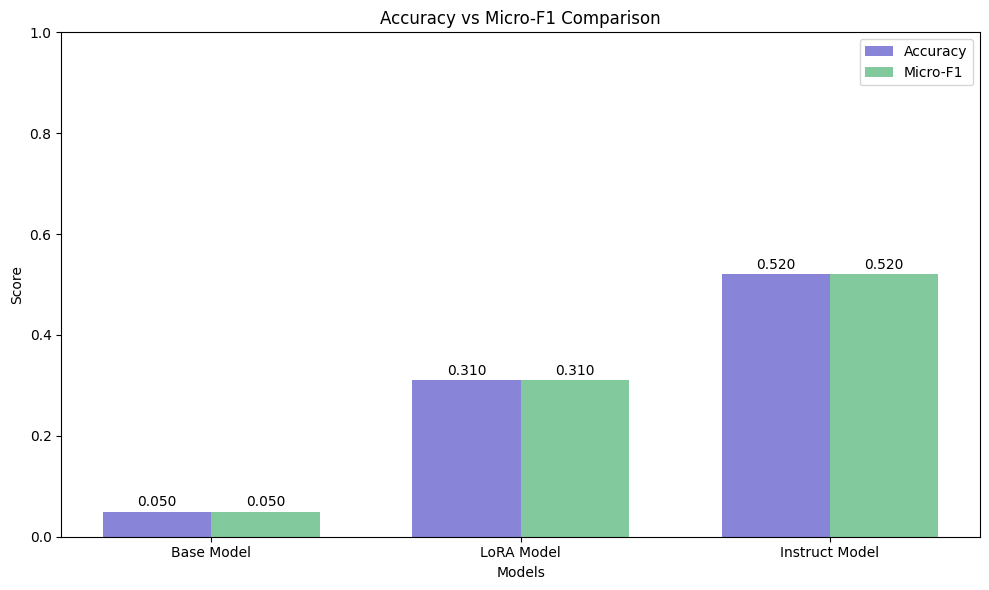

Results:
Base Model: Accuracy = 0.050, Micro-F1 = 0.050
LoRA Model: Accuracy = 0.310, Micro-F1 = 0.310
Instruct Model: Accuracy = 0.520, Micro-F1 = 0.520


In [108]:
### Your Code Here

def plot_accuracy_f1_from_cm(confusion_matrices, model_names, save_path=None):
    """
    Calculate Accuracy and Micro-F1 from confusion matrices and create a grouped bar chart.
    
    Parameters:
    -----------
    confusion_matrices : list of numpy.ndarray
        List of confusion matrices for each model
    model_names : list of str
        Names of the models to display
    save_path : str, optional
        Path to save the figure
    """
    accuracies = []
    micro_f1s = []
    
    # Calculate metrics for each confusion matrix
    for cm in confusion_matrices:
        # Calculate accuracy
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)
        
        # Calculate micro-F1
        tp_sum = np.sum(np.diag(cm))
        fp_sum = np.sum(cm.sum(axis=0) - np.diag(cm))
        fn_sum = np.sum(cm.sum(axis=1) - np.diag(cm))
        
        precision = tp_sum / (tp_sum + fp_sum) if (tp_sum + fp_sum) > 0 else 0
        recall = tp_sum / (tp_sum + fn_sum) if (tp_sum + fn_sum) > 0 else 0
        micro_f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        accuracies.append(accuracy)
        micro_f1s.append(micro_f1)
    
    # Create plot
    x = np.arange(len(model_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, accuracies, width, label='Accuracy', color='#8884d8')
    ax.bar(x + width/2, micro_f1s, width, label='Micro-F1', color='#82ca9d')
    
    # Add formatting
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Accuracy vs Micro-F1 Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylim(0, 1.0)
    ax.legend()
    
    # Add value labels
    for i, v in enumerate(accuracies):
        ax.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center')
    for i, v in enumerate(micro_f1s):
        ax.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
    # Print results
    print("Results:")
    for i, model in enumerate(model_names):
        print(f"{model}: Accuracy = {accuracies[i]:.3f}, Micro-F1 = {micro_f1s[i]:.3f}")

plot_accuracy_f1_from_cm(
        [ev1['confusion_matrix'], ev2['confusion_matrix'], ev3['confusion_matrix']],
        ['Base Model', 'LoRA Model', 'Instruct Model'],
        save_path='model_comparison.png'
    )

#### Q2.11: Analysis (10 pts)

Here, the result are evident. Our LoRA fine-tuned model enhances the base model predictive capabilitiy substantially. It results in about 30% accuracy in the test data. The reason it is able to exceed the base model is obvious. It is a fine-tuned base model that is gone through the fine-tuning for the specific purposes of this task. Also it deploys an instruction format for its input to the model which helps it as well. 

However, out LoRA fine-tuned model is unable to beat the instruct model. This is due to the fact that the instruct model has gone through a more extensive fine-tuning and instructing tuning. Although We could have probably fine-tuned a LoRA model that could beat the instruct model, given enough experiments with different abilations and more training epochs.

Overall, the LoRA fine-tuned model is satisfactory.